# Real NVP

The goal of this notebook is to test the implementation of Real NVP in jax.

In [40]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
import jax.numpy as jnp
import optax
import sbibm
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from typing import Any

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

from chainconsumer import ChainConsumer

jax.config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation model

In [32]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'lotka_volterra',
 'two_moons',
 'sir',
 'slcp',
 'gaussian_linear',
 'bernoulli_glm',
 'gaussian_linear_uniform',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [33]:
task = sbibm.get_task("two_moons")
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim, dim_cond = truth.shape[0], observation.shape[1]

print(dim, dim_cond)

2 2


In [34]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas, dtype=np.float64), np.array(self.xs, dtype=np.float64)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [35]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

## Neural posterior estimation using Real NVP

In [36]:
from normflow.model import ConditionalRealNVP

In [37]:
NF_nvp = ConditionalRealNVP(
    n_in=dim,
    n_layers=4,
    layers=[128, 128],
    activation='relu'
)
NF_nvp

ConditionalRealNVP(
    # attributes
    n_in = 2
    n_layers = 4
    layers = [128, 128]
    activation = 'relu'
)

In [38]:
seed = jax.random.PRNGKey(0)
seed, key = jax.random.split(seed)

params = NF_nvp.init(key, jnp.ones((1, dim)), jnp.ones((1, dim_cond)), method='log_prob')

In [39]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)

NF_nvp.apply(params, thetas, xs, method='log_prob').shape

(54,)

## Training of the network

In [46]:
class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

In [49]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = RealNVPTrainer(n_in=dim,
                         n_layers=4,
                        layers=[128, 128],
                        activation = 'silu',
                        optimizer_hparams={'lr': 4e-3},
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)),
                        check_val_every_epoch=5,
                        seed=0)

In [50]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [51]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.2251585633398956
Validation loss: -3.2140320591091167
Test loss: -3.2142505773306094


In [52]:
model = trainer.bind_model()

In [53]:
key = jax.random.PRNGKey(42)

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

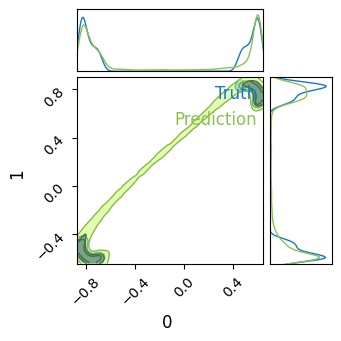

In [54]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

## Optimizing hyperparameter choice with Optuna

In [6]:
import optuna 

CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints'

In [7]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = RealNVPTrainer(n_data=dim, #Create your trainer
                            n_layers=trial.suggest_int('n_layers', 3, 10),
                            layers=[128, 128],
                            activation=jax.nn.silu,
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader)), #beware of the training input.
                            check_val_every_epoch=5,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [64]:
study = optuna.create_study(
    study_name='realnvp_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/realnvp_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-02-15 16:57:08,276] Using an existing study with name 'realnvp_slcp_hparam_search' instead of creating a new one.
[I 2024-02-15 16:58:50,756] Trial 1 finished with value: -1.8116682156794768 and parameters: {'n_layers': 3, 'lr': 0.00016310868067685358}. Best is trial 1 with value: -1.8116682156794768.
[I 2024-02-15 17:03:35,324] Trial 2 finished with value: -3.6068792654759547 and parameters: {'n_layers': 9, 'lr': 0.002400475445764724}. Best is trial 2 with value: -3.6068792654759547.
[I 2024-02-15 17:06:21,235] Trial 3 finished with value: -2.989458473485596 and parameters: {'n_layers': 5, 'lr': 0.0002761822785190321}. Best is trial 2 with value: -3.6068792654759547.
[I 2024-02-15 17:12:02,802] Trial 4 finished with value: -3.625052440464603 and parameters: {'n_layers': 10, 'lr': 0.004618160709987641}. Best is trial 4 with value: -3.625052440464603.
[I 2024-02-15 17:13:44,341] Trial 5 finished with value: -3.1885209343295644 and parameters: {'n_layers': 3, 'lr': 0.002703776519

KeyboardInterrupt: 

In [65]:
trial = study.best_trial
print(f'Best Loss: {trial.value:.2f}')
print(f'Best hyperparameters:')
for key, value in trial.params.items():
    print(f' ->   {key}: {value}')

Best Loss: -3.68
Best hyperparameters:
 ->   n_layers: 10
 ->   lr: 0.00731899868293385


In [42]:
trainer = RealNVPTrainer.load_from_checkpoints(os.path.join(CHECKPOINT_PATH, 'ConditionalRealNVP/version_15/'),
                                               exmp_input=next(iter(train_loader)))
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["loss"]:.2f}')

Test accuracy: -3.67


In [71]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'n_layers'])
fig.show()

In [43]:
model = trainer.bind_model()

In [44]:
key = jax.random.PRNGKey(0) #let's get our samples

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

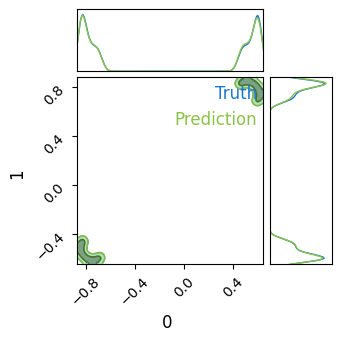

In [45]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples.squeeze(), shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()